<a href="https://colab.research.google.com/github/akankshakusf/Project-DeepLearning-Human-Emotions-Detection-Model/blob/master/DP_Human_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
#Import packages
import numpy as np
from datetime import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
import sklearn
import cv2 #computer vision
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt


#tensorflow packages
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1

# Define main_directory Structure

In [2]:
train_directory="/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

## Params Dictionary

In [49]:

CONFIGURATION={
        "BATCH_SIZE":32,
        "IM_SIZE":256,
        "LEARNING_RATE":0.001,
        "N_EPOCHS":20,
        "DROPOUT_RATE":0.0,
        "REGULARIZATION_RATE":0.0,
        "N_FILTERS":6,
        "KERNEL_SIZE":3,
        "N_STRIDES":1,
        "POOL_SIZE":2,
        "N_DENSE_1":100,
        "N_DENSE_2":10,
        "NUM_CLASSES":3,
        "CLASS_NAMES": ["angry", "happy", "sad"],

}


# Data Management

## Data Downloading- Importing Kaggle Dataset

In [4]:
!pip install -q kaggle

In [5]:
import os
import zipfile

# Make a hidden .kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the folder
!mv kaggle.json /root/.kaggle/

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown


In [7]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

## Dataset Loading

In [8]:
train_dataset= tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical', #one hot endoded
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=32,
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [9]:
val_dataset= tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical', #one hot endoded
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [10]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

## Dataset Visualization

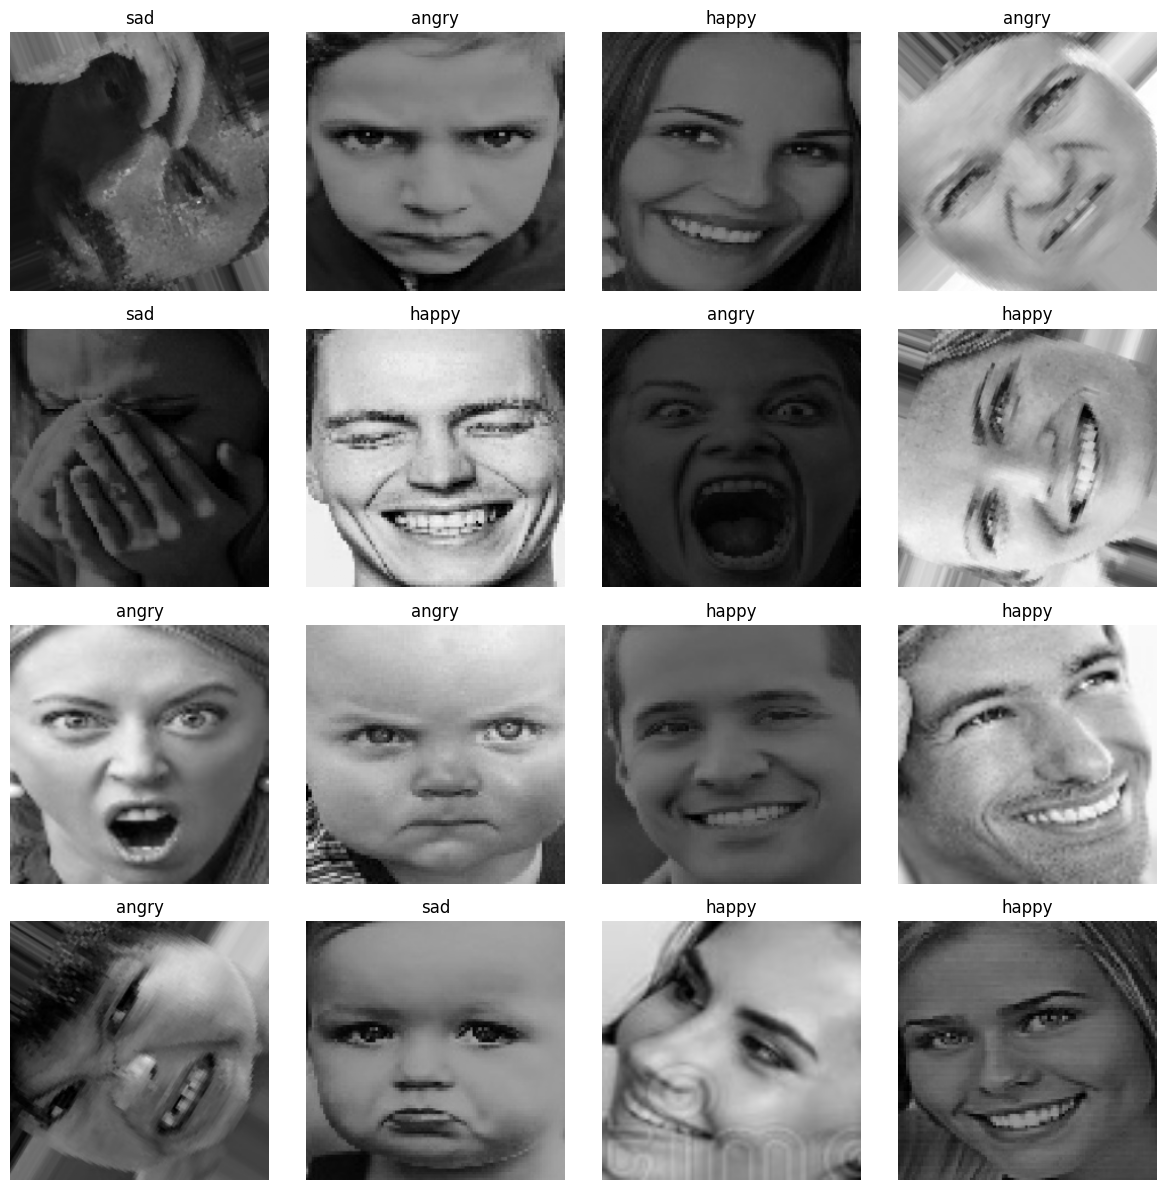

In [11]:
# Get one batch
images, labels = next(iter(train_dataset))
plt.figure(figsize=(12, 12))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy() / 255.0)  # normalize and convert tensor to numpy
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis=0).numpy()])  # convert one-hot to class index
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Augmentation

- reference: https://www.tensorflow.org/api_docs/python/tf/keras/layers

In [12]:
# 1.Augmented layer with "layers method" rotation/flip/contrast
augment_layers = tf.keras.Sequential([
       RandomRotation(factor = (0.25, 0.2501),),
       RandomFlip(mode='horizontal',),
       RandomContrast(factor=0.1),
])

In [13]:
def augment_layer(image,label):
  return augment_layers(image, training=True), label

In [14]:
## 2.Augmented layer with "layers method" for resizing and rescaling
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1.0 / 255),
])

# CutMix Data Augmentation

In [36]:
def box(lamda):

  # Randomly select a center point (x, y) for the patch within the image
  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION['IM_SIZE']).sample(1)[0], dtype=tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION['IM_SIZE']).sample(1)[0], dtype=tf.int32)

  # Calculate the width and height of the patch based on how much of the image we want to replace
  r_w = tf.cast(CONFIGURATION['IM_SIZE'] * tf.math.sqrt(1 - lamda), dtype=tf.int32)
  r_h = tf.cast(CONFIGURATION['IM_SIZE'] * tf.math.sqrt(1 - lamda), dtype=tf.int32)

  # Adjust the top-left corner so the patch stays within image boundaries
  r_x = tf.clip_by_value(r_x - r_w // 2, 0, CONFIGURATION['IM_SIZE'])
  r_y = tf.clip_by_value(r_y - r_h // 2, 0, CONFIGURATION['IM_SIZE'])

  #find the x,y bottom right
  x_b_r= tf.clip_by_value(r_x + r_w // 2, 0, CONFIGURATION['IM_SIZE'])
  y_b_r = tf.clip_by_value(r_y + r_h // 2, 0, CONFIGURATION['IM_SIZE'])

  #final value of r_w,r_h
  r_w = x_b_r - r_x
  if (r_w == 0):
    r_w = 1

  r_h = y_b_r - r_y
  if (r_h == 0):
    r_h = 1

  # Print the top-left corner (r_x, r_y) and size (r_w, r_h) of the patch to be cut and mixed
  return r_y, r_x, r_h, r_w

In [37]:
# Create a method to perform MixUp by combining two training images

def cutmix(train_dataset_1, train_dataset_2):
  # Draw a random value from a Beta distribution to decide how much to mix two images
  lamda = tfp.distributions.Beta(0.2, 0.2)  ### 0.2 is a standard
  lamda = lamda.sample(1)[0]

  r_y,r_x, r_h, r_w = box(lamda)

  # Unpack images and labels from both datasets
  (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  # Cut a rectangular patch from image_2
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  # Place the cropped patch onto a blank canvas (same size as image) at a specific location
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'])

  # Do the same crop and pad for image_1 (to subtract the patch area later)
  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1,r_y, r_x, CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'])

  # Replace the patch in image_1 with the patch from image_2
  image = image_1 - pad_1 + pad_2

  lamda= tf.cast(1-(r_w*r_h)/(CONFIGURATION['IM_SIZE']*CONFIGURATION['IM_SIZE']),dtype=tf.float32)
  label = lamda*tf.cast(label_1,dtype=tf.float32) + (1-lamda)*tf.cast(label_2,dtype=tf.float32)

  # Return the mixed image and the label (currently label_1 only)
  return image, label

## Dataset Preparation

- let tf pre fetch batches in the background while the model is training on the current batch
- let tf automatically choose the optimal number of batches to prefetch based on system performance.

In [38]:
# create a mixed datasets
train_dataset_1= train_dataset.map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_2= train_dataset.map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)

mixed_dataset=tf.data.Dataset.zip(train_dataset_1, train_dataset_2) # comment when using Albumentation

In [15]:
# #prefetch and autotune
# train_dataset=(train_dataset
#                .map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
#                .prefetch(tf.data.AUTOTUNE))

In [39]:
# Training pipeline with augmentation
train_dataset = (
    mixed_dataset
    .map(cutmix,num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [40]:
val_dataset=(val_dataset
             .prefetch(tf.data.AUTOTUNE))

In [41]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [42]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

# Modelling

## Simple Sequential LeNet Model

In [43]:
# clear up session cache
from tensorflow.keras import backend as K
# Clear the previous session to reset layer count
K.clear_session()


In [44]:
'''
1. Instantiate the CNN model "Simple Sequential Model"
'''

lenet_model = tf.keras.Sequential([

    #InputLayer(shape = (None, None, 3), ),
    InputLayer(input_shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),

    resize_rescale_layers, # embedding resize and rescale into SequentialAPI
    augment_layers,

    # 1st conv layer (extracts basic patterns)
    Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"],
           strides=CONFIGURATION["N_STRIDES"],
           padding="valid", activation="relu",
           kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),

    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"],
              strides=CONFIGURATION["N_STRIDES"]*2),  # Downsamples feature maps

    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),   #add a dropout layer

    # 2nd conv layer (extracts deeper features)
    Conv2D(filters=CONFIGURATION["N_FILTERS"]*2+4, kernel_size=CONFIGURATION["KERNEL_SIZE"],
           strides=CONFIGURATION["N_STRIDES"],
           padding="valid", activation="relu",
           kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),

    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),  # Downsampling again


    Flatten(),  # Converts 2D feature maps into 1D array

    Dense(CONFIGURATION["N_DENSE_1"], activation="relu",kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),  # Fully connected layer
    BatchNormalization(),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),   #add a dropout layer

    Dense(CONFIGURATION["N_DENSE_2"], activation="relu",
          kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),   # Further processing
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax"),     # Output layer (multi-class classification)

])

# Print model summary
lenet_model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       6,150,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,153,119 (23.47 MB)

 Trainable params: 6,152,855 (23.47 MB)

 Non-trainable params: 264 (1.03 KB)

# Model Training


In [45]:
loss_function = CategoricalCrossentropy()
#loss_function = SparseCategoricalCrossentropy()

In [46]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [47]:
#compile the model
lenet_model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=loss_function,
    metrics=metrics)

In [ ]:
#fit the model
history = lenet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=CONFIGURATION["N_EPOCHS"],
    verbose=True)

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.4870 - loss: 1.0429 - top_k_accuracy: 0.7734 - val_accuracy: 0.4144 - val_loss: 1.0757 - val_top_k_accuracy: 0.7752
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.5460 - loss: 0.9705 - top_k_accuracy: 0.8186 - val_accuracy: 0.4789 - val_loss: 1.0438 - val_top_k_accuracy: 0.7884
Epoch 3/20


# Visualization

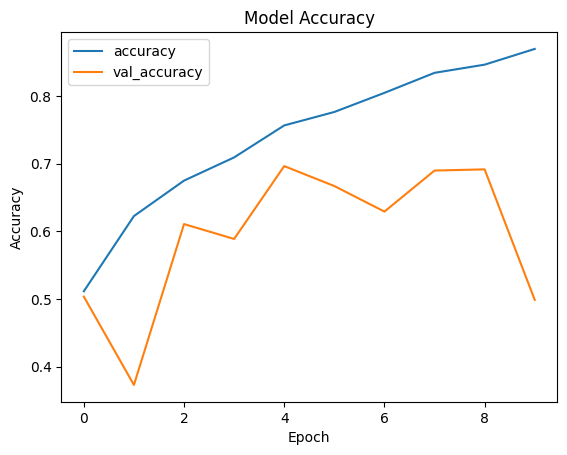

In [25]:
# Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

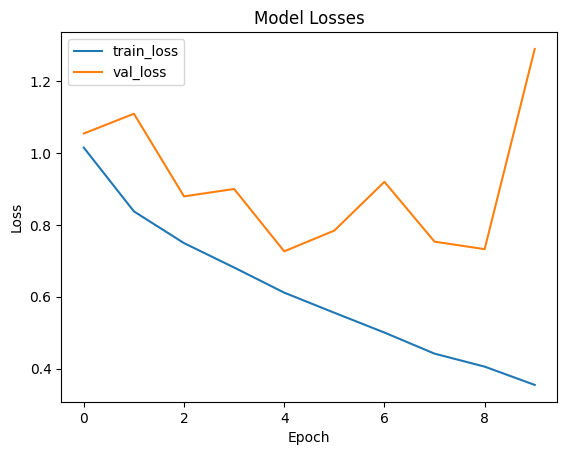

In [26]:
# Model Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

# Model Evaluation

In [27]:
#evaluate model on val data
lenet_model.evaluate(val_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4973 - loss: 1.3016 - top_k_accuracy: 0.7425


[1.2896784543991089, 0.49868306517601013, 0.7532923817634583]

# Model Testing

- 1. testing for happy image

In [28]:
#test an image
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/111073.jpg")

# Convert the image to tensors
im = tf.constant(test_image, dtype=tf.float32)
print(im.shape) # but this needs to be 4 dimensional


#adding batch dimension to shape [1, height, width, channels])
im = tf.expand_dims(im, axis=0)
print(im.shape)

#get predictions (argmax: get max probabilities)
predictions= lenet_model(im)
print(CONFIGURATION["CLASS_NAMES"][tf.argmax(predictions, axis=-1).numpy()[0]])

(90, 90, 3)
(1, 90, 90, 3)
happy


- 2. testing for sad image

In [29]:
#test an image
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/105565.jpg_brightness_1.jpg")

# Convert jpg to tensors
im = tf.constant(test_image, dtype=tf.float32)
print(im.shape) # but this needs to be 4 dimensional

#adding batch dimension to shape [1, height, width, channels])
im = tf.expand_dims(im, axis=0)
print(im.shape)

#get predictions (argmax: get max probabilities)
predictions= lenet_model(im)
print(CONFIGURATION["CLASS_NAMES"][tf.argmax(predictions, axis=-1).numpy()[0]])

(224, 224, 3)
(1, 224, 224, 3)
sad


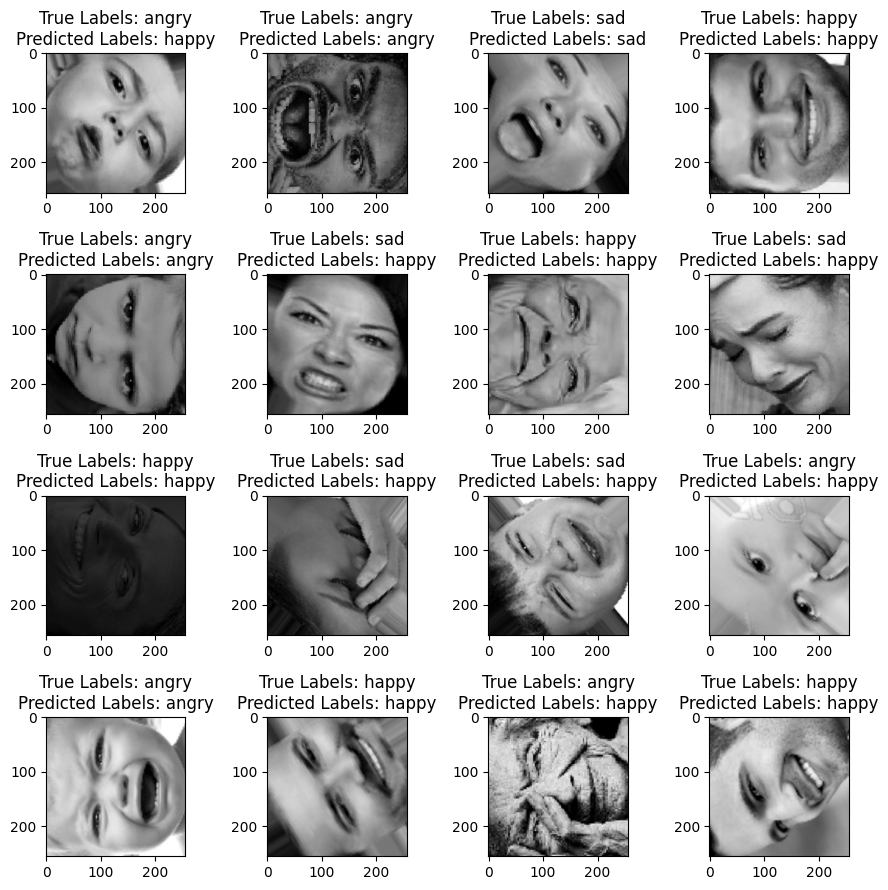

In [30]:
# Get one batch
images, labels = next(iter(train_dataset))
plt.figure(figsize=(9, 9))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy()/ 255.0)  # normalize and convert tensor to numpy

    #titles on images
    plt.title("True Labels: " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis=0).numpy()]+ "\n" +
              "Predicted Labels: " + CONFIGURATION["CLASS_NAMES"][tf.argmax(lenet_model(tf.expand_dims(images[i], axis=0)), axis=-1).numpy()[0]])

plt.tight_layout()
plt.show()

# Confusion Matrix

In [31]:
predicted= []
labels= []

#iterate through the validation ds
for im, label in val_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [32]:
#leave the last batch of 32 and take rest & later flatten the batches

#leaving last batch for now [:-1]
print(np.argmax(labels[:-1], axis= -1).flatten())

#taking just last batch [-1]
print(np.argmax(labels[-1], axis= -1).flatten())

#for labels combining last batch and all batch through concatenation
print(np.concatenate([np.argmax(labels[:-1], axis= -1).flatten(),np.argmax(labels[-1], axis= -1).flatten()]))

#for predicted values combining last batch and all batch through concatenation
print(np.concatenate([np.argmax(predicted[:-1], axis= -1).flatten(),np.argmax(predicted[-1], axis= -1).flatten()]))

[1 0 2 ... 0 1 2]
[2 0 1 0 1 0]
[1 0 2 ... 0 1 0]
[1 1 0 ... 1 1 2]


In [33]:
# predicted and true values
predicted = np.concatenate([np.argmax(predicted[:-1], axis= -1).flatten(),np.argmax(predicted[-1], axis= -1).flatten()]) #what model predicted
labels = np.concatenate([np.argmax(labels[:-1], axis= -1).flatten(),np.argmax(labels[-1], axis= -1).flatten()]) #true values


[[157  63 130]
 [248 814 353]
 [110 129 274]]


Text(0.5, 14.722222222222216, 'Predicted')

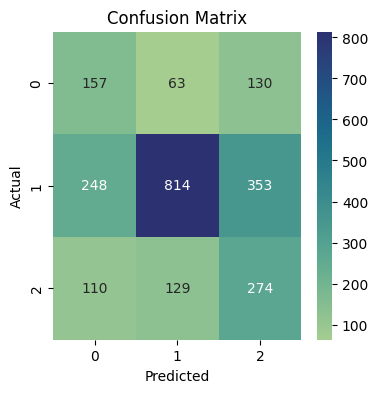

In [34]:
plt.figure(figsize=(4,4))
cm=confusion_matrix(predicted,labels)
print(cm)

sns.heatmap(cm,annot=True, fmt='g',cmap="crest")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")

-The model performed best in recognizing happy, correctly classifying 879 samples. However, it misclassified 132 as angry and 214 as sad.

-For the sad class, the model correctly identified 475 cases, while incorrectly classifying 87 as angry and 93 as happy.

-Recognition of the angry class was weakest, correctly classifying only 294 cases, with 31 misclassified as happy and 67 as sad.

-The large off-diagonal values in the "happy" column indicate a bias towards predicting "happy" more frequently, even when the actual emotion is "angry" or "sad".